# Application 1:  a simple nested cube with no preconditioner

In [2]:
# PARAMETERS

## PHYSICS
k = {
    'e': 1,
    'i': 1,
    'w': 1.2,
}

mu = 1

## COMPUTING
element_size = 0.5

# Imports

In [3]:
import time
from collections import namedtuple
import numpy as np
import bempp.api

from bempp.api import function_space, assembly
from bempp.api.operators.boundary import maxwell


from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

bempp.api.set_ipython_notebook_viewer()

# Create grid

This problem domain consists of two cubes: one large and one small. The small cube is positioned at the center of the large cube.

In [4]:
Space = namedtuple('Space', ['domain', 'range_space', 'dual_to_range'])

def discretize(grid, method="RWG", dtr_method="SNC"):
    """
    Returns a named tuple containing the discretised boundaries of the
    given grid according to the method specified.
    """
    return Space(
        domain=function_space(grid, method, 0),
        range_space=function_space(grid, method, 0),
        dual_to_range=function_space(grid, dtr_method, 0)
    )

# Cubes are centered by default
small_cube = discretize(bempp.api.shapes.cube(length=1, h=element_size))
large_cube = discretize(bempp.api.shapes.cube(length=2, h=element_size))

In [5]:
bempp.api.space.space.Space??

In [16]:
x = large_cube.dual_to_range
print(
    x.domain_dimension,
    x.global_dof_count,
    x.flat_local_dof_count,
    sep='\n'
)
y = small_cube.dual_to_range
print(
    y.domain_dimension,
    y.global_dof_count,
    y.flat_local_dof_count,
    sep='\n'
)
print()
print(x.global_dof_count+y.global_dof_count)
print(x.flat_local_dof_count+y.flat_local_dof_count)

2
390
780
2
126
252

516
1032


# Setup the Operator

$$
\mathcal{A}
=
\begin{bmatrix}
    -(\mathcal{A}^w_1 + \mathcal{A}^1_1) & \mathcal{A}^w_{1,w} \\
    -\mathcal{A}^w_{w,1}               & \mathcal{A}^w_w + \mathcal{A}^e_w \\
\end{bmatrix}
$$

In [27]:
def to_block_op(mfie, efie):
    """
    Build the standard block operator from the given integral equations.
    """
    A = assembly.BlockedOperator(2, 2) # empty operator object
    # NOTE apply scaling like Antigoni?
    A[0,0] = mfie
    A[0,1] = efie
    A[1,0] = -1 * efie
    A[1,1] = mfie
    return A


def get_simple_block_op(space, k):
    """
    Return a 2x2 block operator defining the block matrix that would
    act on the given grid.
    
    This is similar to the `multitrace_operator` constructor, but it
    allows us to specify exactly which boundary disretisation functions
    to use.
    """
    efie = maxwell.electric_field(
        space.domain, space.range_space, space.dual_to_range,k,
    )
    mfie = maxwell.magnetic_field(
        space.domain, space.range_space, space.dual_to_range, k,
    )
    A = to_block_op(mfie, efie)
    
    return A


def get_mixed_block_op(target, source, k):
    """
    Return a 2x2 block operator that defines the interferences on
    `grid_a` by `grid_b`.
    """
    efie = maxwell.electric_field(
        source.domain, target.range_space, target.dual_to_range, k
    )
    mfie = maxwell.magnetic_field(
        source.domain, target.range_space, target.dual_to_range, k
    )
    A = to_block_op(mfie, efie)
    return A
    

def assign_inplace_subblock(A, a, i, j):
    """
    Assigns the 4 elements of a to the 2x2 block of A
    specified by the indexes i and j.
    """
    bi = 2*i
    bj = 2*j
    A[bi, bj]     = a[0, 0]
    A[bi, bj+1]   = a[0, 1]
    A[bi+1, bj]   = a[1, 0]
    A[bi+1, bj+1] = a[1, 1]
    

def PMCHWT_operator(
        small_cube, large_cube, k_int, k_wal, k_ext, mu, parameters
    ):
    """
    Build the operator for the nested shape problem formulation.
    """
    # small cube
    A1_1 = get_simple_block_op(small_cube, k_int)
    Aw_1 = get_simple_block_op(small_cube, k_wal)
    # large cube
    Aw_w = get_simple_block_op(large_cube, k_wal)
    Ae_w = get_simple_block_op(large_cube, k_ext)
    # mixed (target, source, k)
    Aw_1w = get_mixed_block_op(small_cube, large_cube, k_wal)
    Aw_w1 = get_mixed_block_op(large_cube, small_cube, k_wal)
   
    # assemble the blocks
    A = assembly.BlockedOperator(2 * 2, 2 * 2)
    assign_inplace_subblock(A, -(Aw_1 + A1_1), 0, 0)
    assign_inplace_subblock(A,   Aw_1w,        0, 1)
    assign_inplace_subblock(A, - Aw_w1,        1, 0)
    assign_inplace_subblock(A,   Aw_w + Ae_w,  1, 1)
    
    return A

    
A = PMCHWT_operator(small_cube, large_cube, k['i'], k['w'], k['e'], None, None)

In [33]:
spaces_in_A = [d.flat_local_dof_count for d in A._range_spaces]
print([d for d in A._domain_spaces], sep='\n')
print(spaces_in_A)
print(sum(spaces_in_A))

[<bempp.api.space.space.RWGSpace object at 0x7f69022eafd0>, <bempp.api.space.space.RWGSpace object at 0x7f69022eafd0>, <bempp.api.space.space.RWGSpace object at 0x7f69022fd9e8>, <bempp.api.space.space.RWGSpace object at 0x7f69022fd9e8>]
[252, 252, 780, 780]
2064


# Discretize the incident field

In [5]:
#
# Antigoni's code
#
if False:
    def incident_field(x):
        return np.array([0. * x[2], 0. * x[2], np.exp(1j * k_ext * x[0])])


    def dirichlet_trace_fun(x, n, domain_index, result):
        result[:] = np.cross(incident_field(x), n)


    def curl(incident_field,x):
        return np.array([0,  - 1j * k_ext * np.exp(1j * k_ext * x[0]), 0])


    def neumann_trace_fun(x, n, domain_index, result):
        result[:] = (1/(1j * k_ext)) * np.cross(curl(incident_field,x), n)


    incident_field_RWG = number_of_scatterers * [None]
    for i in range(number_of_scatterers):
        dirichlet_trace_RWG = bempp.api.GridFunction(rwg_space[i], fun=dirichlet_trace_fun)
        neumann_trace_RWG = (k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun = neumann_trace_fun)
        incident_field_RWG[i] = dirichlet_trace_RWG.coefficients.tolist() +  neumann_trace_RWG.coefficients.tolist()

In [92]:
def incident_field(x):
    return np.array([0. * x[2], 0. * x[2], np.exp(1j * k['e'] * x[0])])


def dirichlet_trace_fun(x, n, domain_index, result):
    result[:] = np.cross(incident_field(x), n)

    
def curl(incident_field,x):
    return np.array([0,  - 1j * k['e'] * np.exp(1j * k['e'] * x[0]), 0])


def neumann_trace_fun(x, n, domain_index, result):
    result[:] = (1/(1j * k['e'])) * np.cross(curl(incident_field,x), n)

# for small cube
Dtrace_small = bempp.api.GridFunction(large_cube.domain, fun=dirichlet_trace_fun)
Ntrace_small = (k['e']/mu) * bempp.api.GridFunction(large_cube.domain, fun=neumann_trace_fun)
# for large cube
Dtrace_large = bempp.api.GridFunction(large_cube.domain, fun=dirichlet_trace_fun)
Ntrace_large = (k['e']/mu) * bempp.api.GridFunction(large_cube.domain, fun=neumann_trace_fun)
# combine
u_inc = [
    Dtrace_small.coefficients.tolist() + Ntrace_small.coefficients.tolist(),
    Dtrace_large.coefficients.tolist() + Ntrace_large.coefficients.tolist()
]

In [93]:
print(len(u_inc[0]))
print(len(u_inc[1]))

780
780


# Assemble the RHS

$$
f = \begin{bmatrix}
    - \mathcal{A_{1w}} \\
    - (\mathcal{A_{w}} - \frac{1}{2} \mathcal{I})
\end{bmatrix}
$$

In [94]:
def get_identity_op(space):
    """
    Create an identity operator matching the given space
    """
    i = bempp.api.operators.boundary.sparse.identity(
        space.domain, space.range_space, space.dual_to_range
    )
    I = assembly.BlockedOperator(2, 2)
    I[0, 0] = i
    I[1, 1] = i
    return I
    

Aw_1w = get_mixed_block_op(small_cube, large_cube, k['w'])
Aw_w  = get_simple_block_op(large_cube, k['w'])
I = get_identity_op(large_cube)

In [95]:
print([d.flat_local_dof_count for d in Aw_1w._domain_spaces])
print([d.flat_local_dof_count for d in Aw_1w._range_spaces])
print([d.flat_local_dof_count for d in Aw_w._domain_spaces])
print([d.flat_local_dof_count for d in Aw_w._range_spaces])
print(I._domain_spaces[0].flat_local_dof_count)

[780, 780]
[252, 252]
[780, 780]
[780, 780]
780


In [96]:
len(u_inc[0])

780

In [97]:
Aw_1w.weak_form()

<252x780 BlockedDiscreteOperator with dtype=complex128>

In [98]:
pre = [
    - Aw_1w.weak_form() * u_inc[0],
    - (Aw_w.weak_form() - 1/2 * I.weak_form()) * u_inc[1]
]
# flatten list of lists
f = [y for x in pre for y in x]

# Solve the Linear System

In [60]:
from antigoni.login import gmres

In [54]:
if False:
    c_PMCHWT_nu_sf, info_PMCHWT_nu_sf, res_PMCHWT_nu_sf = gmres(
        PMCHWT_nu_sf, rhs_nu_sf, tol=tolerance, restart=restart,
        return_residuals=True, maxiter=maxiter
    )

In [102]:
# In the last run this stoped convergin around i=4000
# consider setting maxiter to this number for testing
x, info, residuals = gmres(A.weak_form(), f, return_residuals=True)

# Plot

In [122]:
import matplotlib.pyplot as plt

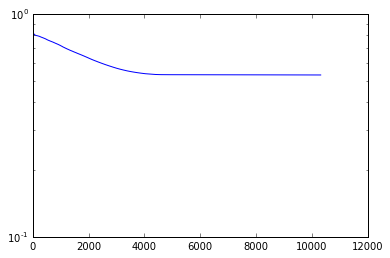

In [128]:
plt.semilogy(residuals);